In [2]:
%matplotlib inline

import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import utils
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [3]:
GTZAN_DIR = '/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/GTZAN_data/'

In [4]:
filename = utils.get_audio_path(GTZAN_DIR, 1, 'blues')
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/GTZAN_data/genres_original/blues/blues.00001.wav
Duration: 30.01s, 661794 samples


/var/folders/v3/49xwmkw17sjdq3cp1fp4wptr0000gn/T/ipykernel_86315/3988748346.py:1: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(x, sr, alpha=0.5)


(-1.0, 1.0)

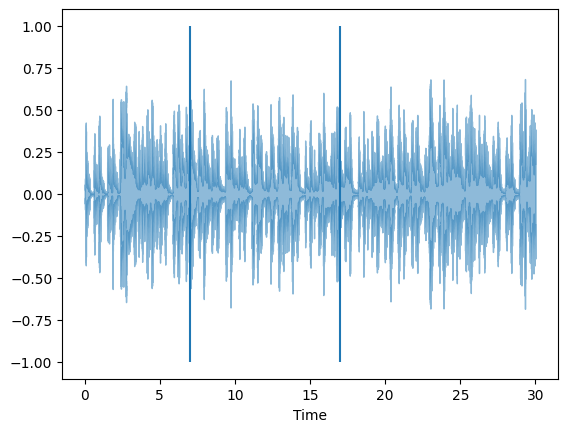

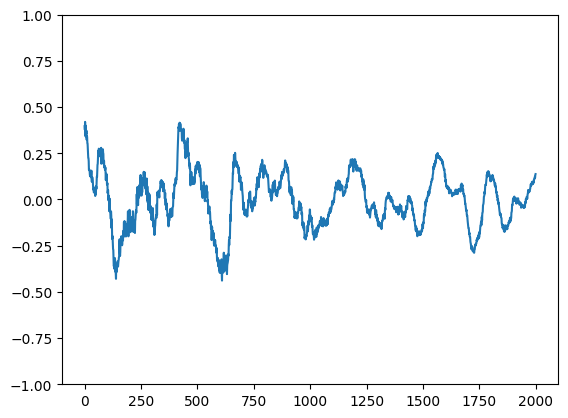

In [5]:
librosa.display.waveshow(x, sr, alpha=0.5)
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

In [6]:
df = pd.read_csv(GTZAN_DIR+"features_30_sec.CSV")

In [7]:
ipd.display(df.head())

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [8]:
features = df[['filename','label']].copy()
features[['ZRC' + str(ind) for ind in range(1,31)]] = 0
features[['MFCC' + str(ind) for ind in range(1,61)]] = 0


In [9]:
for i in range(features.shape[0]):

    try:
        track_id = int(features['filename'][i].split('.')[1])
        
        filename = utils.get_audio_path(GTZAN_DIR, track_id, features['label'][i])

        x, sr = librosa.load(filename, sr=None, mono=True)

        chunkSize = x.size//30

        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=30)
        mfcc_mean_var = np.array([[np.mean(mfcc[i]), np.var(mfcc[i])] for i in range(mfcc.shape[0])])
        
        for j in range(30):
            if j*chunkSize+chunkSize < x.size:
                audio_chunk = x[j*chunkSize:j*chunkSize+chunkSize]
                f = librosa.feature.zero_crossing_rate(audio_chunk, frame_length=2048, hop_length=512) 
                features.loc[i, 'ZRC'+str(j+1)] = f.mean()
                features.loc[i, 'MFCC'+str(j + 1)] = mfcc_mean_var[j][0]
                features.loc[i, 'MFCC'+str(30 + j + 1)] = mfcc_mean_var[j][1]

    except Exception as e:
        print('{}: {}'.format(i, repr(e)))
    
features.head()        

/Users/nkkaushal/Documents/Fall22/ECS_271/Project/venv/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


554: NoBackendError()


,filename,label,ZRC1,ZRC2,ZRC3,ZRC4,ZRC5,ZRC6,ZRC7,ZRC8,...,MFCC51,MFCC52,MFCC53,MFCC54,MFCC55,MFCC56,MFCC57,MFCC58,MFCC59,MFCC60
0,blues.00000.wav,blues,0.077725,0.074862,0.088057,0.099931,0.066950,0.088967,0.063288,0.074141,...,37.975147,31.488348,38.065762,42.761261,62.437622,54.038712,54.862373,49.142673,60.650375,96.925056
1,blues.00001.wav,blues,0.025280,0.020386,0.070601,0.052934,0.051214,0.042547,0.103316,0.098322,...,42.831181,45.852238,39.534351,70.407516,61.689137,60.668659,55.576843,83.738350,76.618752,93.996033
2,blues.00002.wav,blues,0.067150,0.111017,0.051270,0.060769,0.062511,0.050138,0.069491,0.082275,...,43.534809,59.226582,49.701614,52.377888,61.743401,39.243927,50.806229,53.739944,59.712727,54.104553
3,blues.00003.wav,blues,0.013017,0.027832,0.031416,0.031095,0.015303,0.047419,0.030118,0.027854,...,34.790207,31.204569,28.416183,22.890345,23.459158,28.052565,27.928999,26.410456,26.438545,25.622776
4,blues.00004.wav,blues,0.068881,0.095681,0.087646,0.215299,0.140314,0.077581,0.073819,0.148671,...,67.479973,61.050777,54.035244,47.162975,70.380272,81.353638,72.931503,44.619720,58.191410,81.264969


In [10]:
features.to_csv('dataset/GTZAN_DATA/features.csv', index=False)